<a href="https://colab.research.google.com/github/albertaillet/CLIPLSD/blob/colab-setup/notebooks/experiment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   Clone repo and from correct branch
*   Download the pretrained stylegan2 model from https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/






In [1]:
!git clone --branch colab-setup https://github.com/albertaillet/CLIPLSD/
!wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl -P CLIPLSD/pretrained/stylegan2

fatal: destination path 'CLIPLSD' already exists and is not an empty directory.
--2022-04-06 12:12:27--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 18.65.229.52, 18.65.229.112, 18.65.229.23, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|18.65.229.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381624121 (364M) [binary/octet-stream]
Saving to: ‘CLIPLSD/pretrained/stylegan2/ffhq.pkl.1’

ffhq.pkl.1          100%[===================>] 363.94M   253MB/s    in 1.4s    

2022-04-06 12:12:29 (253 MB/s) - ‘CLIPLSD/pretrained/stylegan2/ffhq.pkl.1’ saved [381624121/381624121]



In [2]:
!pip install -r CLIPLSD/requirements.txt
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-2j0zv_b5
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-2j0zv_b5


In [3]:
%cd CLIPLSD/

/content/CLIPLSD


In [4]:
#%load_ext autoreload
#%autoreload 2

import warnings
warnings.filterwarnings("ignore")
import sys
import torch

import matplotlib.pyplot as plt
import numpy as np
import cv2
from IPython.display import Image 

import clip
import models
from utils.stylegan2_utils import StyleGAN2SampleGenerator

In [5]:
", ".join(clip.available_models())

'RN50, RN101, RN50x4, RN50x16, RN50x64, ViT-B/32, ViT-B/16, ViT-L/14'

In [6]:
device = torch.device('cuda')

exp_dir = "out"
G2 = models.get_model("stylegan2", "pretrained/stylegan2/ffhq.pkl")
sample_generator = StyleGAN2SampleGenerator(G=G2, device=device)
clip_model, preprocess = clip.load("ViT-B/32")
_ = clip_model.cuda().eval()

In [7]:
def get_similarity(original_images, descs):
  
  images = [preprocess(img) for img in original_images]
  image_input = torch.tensor(np.stack(images)).cuda()

  texts = ["This is a person with " + desc for desc in descs]
  text_tokens = clip.tokenize(texts).cuda()

  with torch.no_grad():
    image_features = clip_model.encode_image(image_input).float()
    text_features = clip_model.encode_text(text_tokens).float()
  image_features /= image_features.norm(dim=-1, keepdim=True)
  text_features /= text_features.norm(dim=-1, keepdim=True)

  similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

  plt.figure(figsize=(20, 15))
  plt.imshow(similarity, vmin=0.1, vmax=0.3)
  plt.yticks(range(len(texts)), texts, fontsize=18)
  plt.xticks([])
  for i, image in enumerate(original_images):
      plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.5, -0.5), origin="lower", )
  for x in range(similarity.shape[1]):
      for y in range(similarity.shape[0]):
          plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

  for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

  plt.xlim([-0.5, batch_size - 0.5])
  plt.ylim([len(texts) + 0.5, -2])

  return plt.title("Cosine similarity between text and image features", size=20)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


Text(0.5, 1.0, 'Cosine similarity between text and image features')

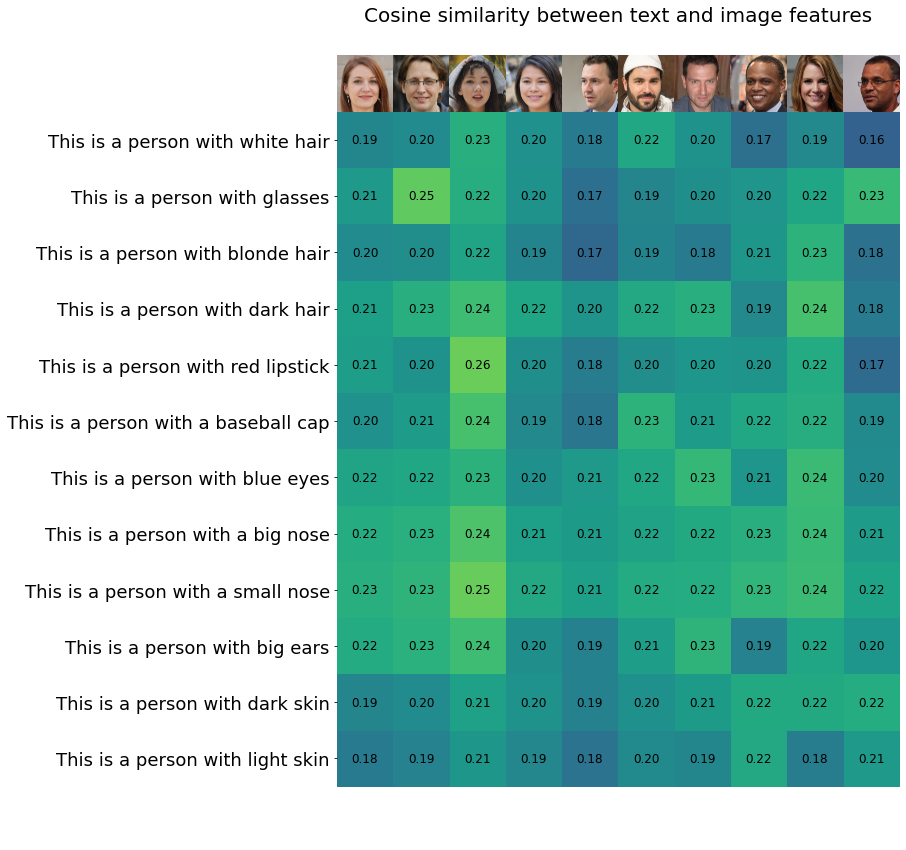

In [8]:
seed = 0
batch_size = 10
batch_data = sample_generator.generate_batch(seed, return_image=True, batch_size=batch_size)
descs = ["white hair", "glasses", "blonde hair", "dark hair", "red lipstick", "a baseball cap", "blue eyes", "a big nose", "a small nose", "big ears", "dark skin", "light skin"]
get_similarity(batch_data["image"], descs)

In [13]:
ws = batch_data["ws"]
ws[:, 1, :] += 1

Text(0.5, 1.0, 'Cosine similarity between text and image features')

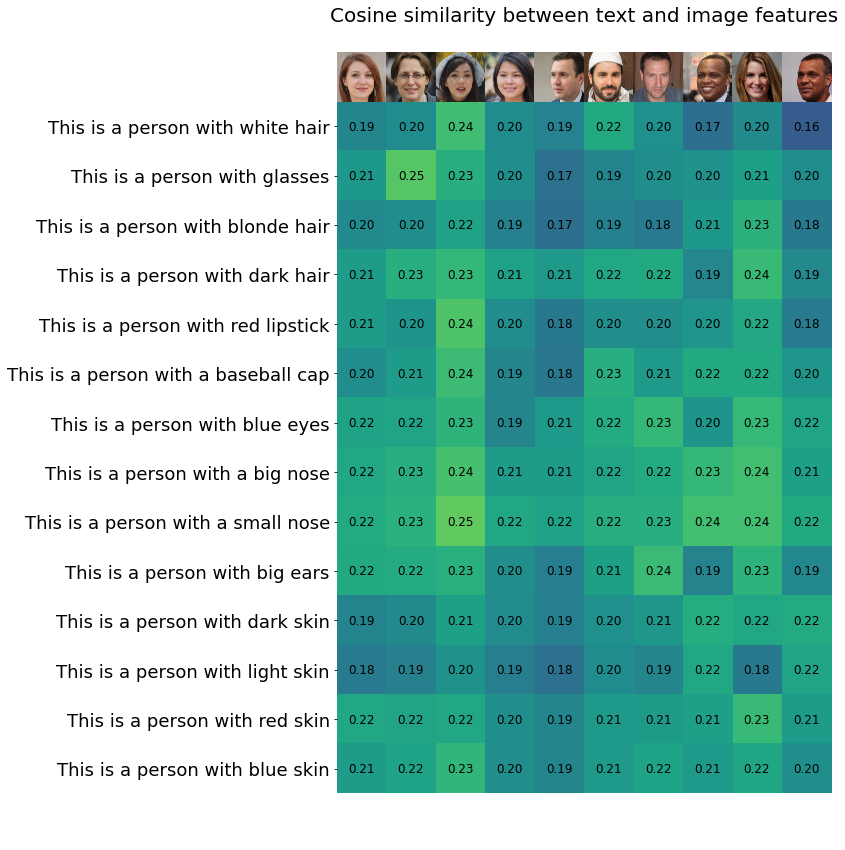

In [16]:
new_batch_data = sample_generator.generate_batch_from_ws(ws, return_image=True)
descs = ["white hair", "glasses", "blonde hair", "dark hair", "red lipstick", "a baseball cap", "blue eyes", "a big nose", "a small nose", "big ears", "dark skin", "light skin", "red skin", "blue skin"]
get_similarity(new_batch_data["image"], descs)